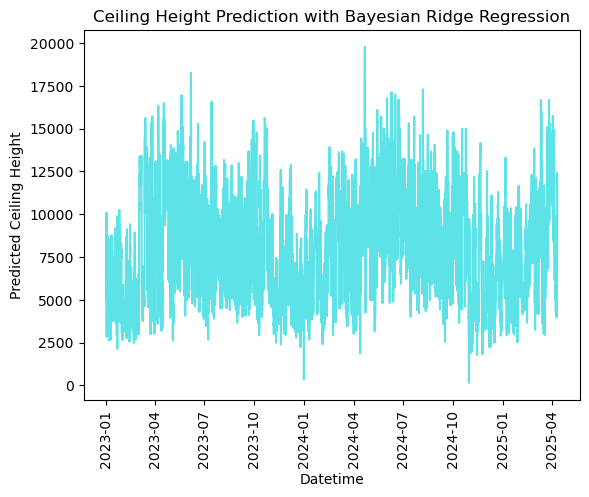

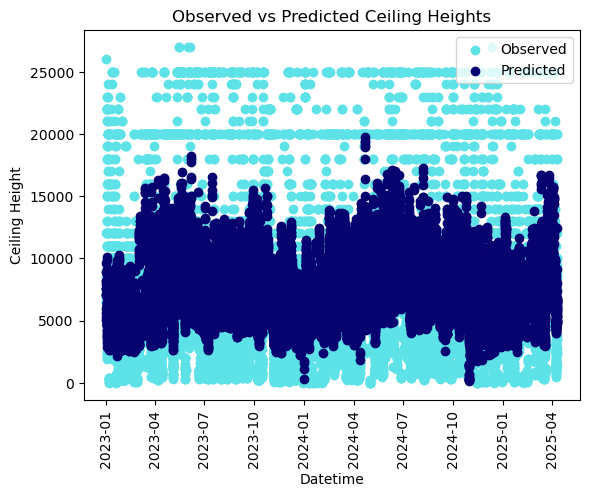

RMSE: 
25096919.383128192


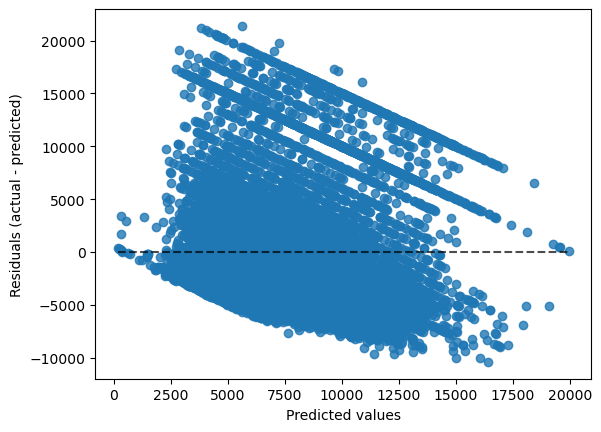

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

# import METAR values with date parsing
METAR = pd.read_csv('PANC_METAR_cleaned.csv', parse_dates=['valid'])

# sort dates - required for rolling average function
METAR = METAR.set_index("valid").sort_index()

# calculate 3-hour rolling averages (prediction variables)
predictions = pd.DataFrame({
    'temperature_3hour_average' : METAR['tmpf'].rolling("3h").mean(), 
    'humidity_3hour_average' : METAR['relh'].rolling("3h").mean(), 
    'dewpoint_3hour_average' : METAR['dwpf'].rolling("3h").mean(), 
    'windspeed_3hour_average' : METAR['sknt'].rolling("3h").mean()
})

predictions = predictions.dropna() # delete NaN rows

# define target and aligh Y axis
Y = METAR.loc[predictions.index, "ceiling"] # target variables

# Bayesian Ridge linear regression model
BayesianRidge = BayesianRidge()
BayesianRidge.fit(predictions, Y)
BayesianRidgePrediction = BayesianRidge.predict(predictions)
plt.plot(predictions.index, BayesianRidgePrediction, label='Bayesian Prediction', color='#5DE2E7')
plt.title("Ceiling Height Prediction with Bayesian Ridge Regression")
plt.xlabel("Datetime")
plt.ylabel("Predicted Ceiling Height")
plt.xticks(rotation=90)
plt.show()

# Show Observed vs Predicted Ceiling Heights
plt.scatter(predictions.index, Y, label='Observed', color='#5DE2E7')
plt.scatter(predictions.index, BayesianRidgePrediction, label='Predicted', color='#060270')
plt.title("Observed vs Predicted Ceiling Heights")
plt.xlabel("Datetime")
plt.ylabel("Ceiling Height")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Show Prediction Error
ridge = Ridge().fit(predictions, Y)
y_pred = ridge.predict(predictions)
display = PredictionErrorDisplay(y_true=Y, y_pred=y_pred)
display.plot()
plt.show()

# Calculate RMSE to evaluate model prediction accuracy
rmse=mean_squared_error(Y, BayesianRidgePrediction)
print("RMSE: ")
print(rmse)